## 🔑 OpenAI API Key

In [ ]:
from dotenv import load_dotenv
import os

load_dotenv()

OPENAI_KEY = os.getenv("OPENAI_API_KEY")

## 📚 Imports

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import openai
from IPython.display import display

import traceback
import re # To clean the LLM Output

## 📥 Load datasets


In [ ]:
yt_df = pd.read_csv("data/youtube_data.csv")
rd_df = pd.read_csv("data/reddit_data.csv")

## 🧹 Previews


In [6]:
print("🎥 YouTube data shape:", yt_df.shape)
print("📕 Reddit data shape:", rd_df.shape)

🎥 YouTube data shape: (25, 5)
📕 Reddit data shape: (66, 13)


## 🎯 Aggregated Sentiment Analysis


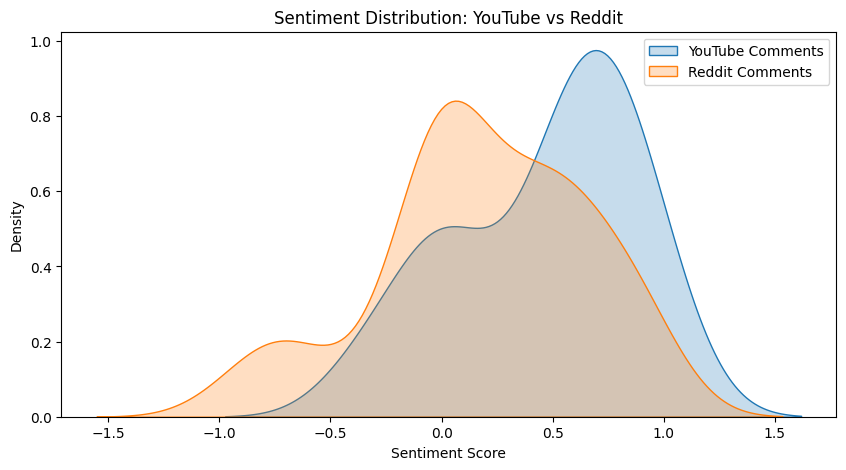

In [ ]:
# Create plot
plt.figure(figsize=(10, 5))
sns.kdeplot(yt_df['comment_sentiment'], label='YouTube Comments', fill=True)
sns.kdeplot(rd_df['comment_sentiment'], label='Reddit Comments', fill=True)
plt.title('Sentiment Distribution: YouTube vs Reddit')
plt.xlabel('Sentiment Score')
plt.ylabel('Density')
plt.legend()
plt.show()

# Save image
plt.savefig("data/sentiment_distribution.png", bbox_inches="tight")
plt.close()

## 📊 Average Sentiment Comparison


In [8]:
avg_sentiments = pd.DataFrame({
    'Platform': ['YouTube', 'Reddit'],
    'Avg Comment Sentiment': [yt_df['comment_sentiment'].mean(), rd_df['comment_sentiment'].mean()]
})
display(avg_sentiments)

,Platform,Avg Comment Sentiment
0,YouTube,0.464348
1,Reddit,0.185512


## 🧠 Create grouped summaries for LLM


In [18]:
topics = yt_df['video_title'].unique()
final_outputs = []

for topic in topics:
    yt_comments = yt_df[yt_df['video_title'] == topic]['comment'].dropna().tolist()
    reddit_rows = rd_df[rd_df['youtube_title'] == topic]
    reddit_post = reddit_rows['reddit_post_title'].unique()[0] if not reddit_rows.empty else "No Reddit post found"
    reddit_comments = reddit_rows['comment'].dropna().tolist()

    if not yt_comments and not reddit_comments:
        continue

    # ✅ Cleaned, limited comments for brevity
    yt_sample = "\n- ".join(yt_comments[:3])
    rd_sample = "\n- ".join(reddit_comments[:3])

    # ✅ Full prompt passed to model
    user_prompt = f"""
Video Title: {topic}
Reddit Post Title: {reddit_post}

🟦 YouTube Comments:
- {yt_sample}

🟥 Reddit Comments:
- {rd_sample}
    """

    try:
        response = client.chat.completions.create(
            model="gpt-4o",
            messages=[
                {
                    "role": "system",
                    "content": "You are a social media analyst. Analyze public perception around this topic using the comments from YouTube and Reddit. Provide a concise summary and highlight any sentiment trends or contrasting opinions between platforms."
                },
                {
                    "role": "user",
                    "content": user_prompt.strip()
                }
            ],
            temperature=0.7
        )
        output = response.choices[0].message.content
    except Exception as e:
        output = f"⚠️ Error for topic: {topic} | {str(e)}"
        print(traceback.format_exc())

    final_outputs.append({
        "topic": topic,
        "reddit_post_title": reddit_post,
        "llm_analysis": output
    })

## 📋 Show results

In [68]:
llm_df = pd.DataFrame(final_outputs)

# Using Regular Expressions to clean the LLM Output
def clean_llm_output(text):
    # Remove Markdown bold/italic
    text = re.sub(r"\*\*(.*?)\*\*", r"\1", text)
    text = re.sub(r"\*(.*?)\*", r"\1", text)
    # Remove Headers
    text = re.sub(r"\#+", r"", text)
    # Remove newlines and excessive spacing
    text = re.sub(r"\n+", "\n", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text.strip()

# Applying the cleaning function to the 'llm_analysis' column
llm_df['llm_analysis'] = llm_df['llm_analysis'].apply(clean_llm_output)

llm_df.head()

,topic,reddit_post_title,llm_analysis
0,Doechii - Anxiety (Official Video),Doechii - Anxiety (Official Music Video),Based on the comments from both YouTube and Re...
1,THE GASLIGHT DISTRICT: PILOT,With the Pilot of the Gaslight District releas...,"Summary:\nThe public perception of ""The Gaslig..."
2,Man. United vs. Lyon: Extended Highlights | UE...,Man. United vs. Lyon: Extended Highlights | UE...,Summary:\nThe public perception surrounding th...
3,The Fantastic Four: First Steps | Official Tra...,The Fantastic Four: First Steps | Official Tra...,Based on the comments from both YouTube and Re...
4,The Best Things In Life Are Unexpected... WE'R...,AITA for telling my mom I can't make my baby s...,"The YouTube comments on the video ""The Best Th..."


In [73]:
for llm_analysis in llm_df['llm_analysis']:
    print(llm_analysis, end="\n\n\n")

Based on the comments from both YouTube and Reddit, public perception of Doechii's "Anxiety" official video seems to be generally positive with some contrasting opinions.
YouTube Trends:
- The comments on YouTube are mixed, with some expressing appreciation and others being critical. For instance, one commenter praised the video indirectly, while another criticized it by calling it a "cheap version" of a well-known song, indicating a negative sentiment.
Reddit Trends:
- On Reddit, the sentiment is more positive. Comments highlight appreciation for the creativity of the music video and the references to both Gotye and Kimbra, as well as Doechii's earlier work. Users seem to recognize and appreciate the artistic elements and the homage to her past work.
Contrasting Opinions:
- The primary contrast between platforms is the presence of critical opinions on YouTube, which are not evident on Reddit. YouTube has a more diverse range of sentiments, while Reddit comments are overwhelmingly posi

## Saving to csv

In [ ]:
llm_df.to_csv("data/llm_insights.csv", index=False)